# ESS: Analysing and interpreting FDEM data - PC class 1 (29.04.2024)
---
# 0 - Introduction
In this notebook you will explore FDEM data, evaluating the spatial variations and how the collected datasets relate to different soil volumes. By combining collected datasets in a GIS, you can explore how the observed variations relate to known soil information. In a last step, you will be able to evaluate the collected data in a more quantitative way by performing an inversion.

This notebook consists of Markdown (text) cells, such as this one, and code cells like the one below. Each code cell is numbered for reference. The first code cell below is **_code cell 0.0_**. Running that cell and **_code cell 0.1_**  installs the required packages in Google Colaboratory, and subsequently import all required packages into the workspace.

Throughout the notebook, in cases where you perform data analyses, the part of the code where you can modify variables, or write functions, always appears above a commented line of asterisks, like this: `# ******* `. If no asterisk line is present in a code cell, this means you can simply run the code cell without changing anything to get the output.

In [28]:
# Import required packages for setup
# -------------------------------------------- #

import sys
import os

In [29]:
# Set the repository path:
# If the code is run in Google Colab This code will check if the repository is already cloned, if not it will clone it
# If the code is run locally, the repository path is set to the local path
# -------------------------------------------- #

if 'google.colab' in sys.modules:

    repo_path = '/content/I002658A_ESS'
    if not os.path.exists(repo_path):
        !git clone --branch funcbr https://github.com/SENSE-UGent/I002658A_ESS.git
    if repo_path not in sys.path:
        sys.path.append(repo_path)

else:

    repo_path = r'c:/Users/pdweerdt/Documents/Repos/I002658A_ESS' # Change this to the location of the repository on your machine
    if repo_path not in sys.path:
        sys.path.append(repo_path) 

# Import the setup function
from Utils.setup import check_and_install_packages

# Read the requirements.txt file

requirements_path = repo_path + '/Utils/requirements.txt'

with open(requirements_path) as f:
    required_packages = f.read().splitlines()

# Check and install packages
check_and_install_packages(required_packages)

In [30]:
# Import the utility functions
from Utils.func import interpolate, export_grid, lin_sens

In [31]:
# 0.1: Import packages into workspace
# -----------------------------------------------------
'''
Import the required modules to run all code in this notebook.
'''
# General utility modules
import warnings
import re
import requests

# Data visualisation, manipulation, and analysis
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.path
from matplotlib.backends.backend_pdf import PdfPages
from scipy.spatial import cKDTree
import scipy.stats
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root

# # Geospatial data manipulation and raster operations
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter

from shapely.geometry import Point

# EMI 1D inversion package (emagpy)
from emagpy import Problem

# Additional settings
warnings.filterwarnings('ignore')
%matplotlib inline

## Set the Working Directory

Do this to simplify subsequent reads and writes (avoid including the full address each time). 

### For use in Google Colab

Run the following cell if you automatically want to get the data from the repository and store it on your Google Colab drive

In [32]:
# change the working directory to the cloned repository

# os.chdir('I002658A_ESS')

# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

Current Working Directory is  c:\Users\pdweerdt\Documents\Repos


### For local use

Only run the following cell if you have the data locally stored.

In [33]:
# set the working directory, place an r in front to address special characters
os.chdir(r'c:/Users/pdweerdt/Documents/Repos')

# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

Current Working Directory is  c:\Users\pdweerdt\Documents\Repos


### Field dataset - Testfield Proefhoeve Bottelaere [Vijverhoek, Oosterzele]

The key dataset you will work with in this notebook, is the frequency-domain electromagnetic induction (FDEM) dataset that was collected at our testsite on April 4, 2025. Data were collected with a Dualem-21HS instrument. Based on the soil map, soil texture in the test site ranges from sandy loam to clay. WRB soil groups are Cambisols (Eutric Stagnic Cambisols (Loamic)) and Stagnosols (Dystric Retic Stagnosols (Loamic)), both are generally Ruptic (referring to the occurrence of two different source materials, in this case aeolian sand/loess over Tertiary clay). You can explore the soil map, along with the WRB classification, in **_code cell 0.2_**.

The data you have are collected with a FDEM instrument with the following specifications:
- operating frequency: 9000 Hz
- coil geometries:
    1. three coil pairs in HCP mode with Rx at 0.5 m (HCP0.5), 1.0 m (HCP2.1), 2.0 m (HCP2.0) from Tx.
    2. three coil pairs in PRP mode with Rx at 0.6 m (PRP0.6), 1.1 m (PRP1.1), 2.1 m (PRP2.1) from Tx.
- output: QP data as LIN ECa [mS/m], IP data as field intensity [ppt].

Table 1 below lists all columns of the FDEM datasets, and explains their datatype.

> 
>|Column name|datatype|
>|-----------|--------|
>| *x* | easting [m]|
>| *y* | northing [m]|
>| *z* | elevation [m]|
>| *t* | timestamp [s]|
>| *HCP0.5* | 0.5 m HCP LIN ECa data [mS/m]|
>| *PRP0.6* | 0.6 m PRP LIN ECa data [mS/m]|
>| *HCP1.0* | 1.0 m HCP LIN ECa data [mS/m]|
>| *PRP1.1* | 1.1 m PRP LIN ECa data [mS/m]|
>| *HCP2.0* | 2.0 m HCP LIN ECa data [mS/m]|
>| *PRP2.1* | 2.1 m PRP LIN ECa data [mS/m]|
>| *HCP0.5_inph* | 0.5 m HCP inphase data [ppt]|
>| *PRP0.6_inph* | 0.6 m PRP inphase data [ppt]|
>| *HCP1.0_inph* | 1.0 m HCP inphase data [ppt]|
>| *PRP1.1_inph* | 1.1 m PRP inphase data [ppt]|
>| *HCP2.0_inph* | 2.0 m HCP inphase data [ppt]|
>| *PRP2.1_inph* | 2.1 m PRP inphase data [ppt]|
>
> *Table 1: overview of FDEM data column names and the datatype these hold.*
>*(The x and y coordinates are presented in meters Belge Lambert 72 (EPSG:31370), and the elevation (z) in meters above sea level.)* 

Basic processing has been performed, which entails:
- accurate georeferencing and projection to Belge Lambert 1972 coordinate system,
- removal of erroneous datapoints (e.g., standstill moments when the survey setup stopped for >5 seconds),
- drift correction (of all IP and QP/ECa datasets).


In [34]:
# 0.2: Exploring test site geodata from 'geopunt.be'
# --------------------------------------------------

 # Modules for geopunt data visualisation
from IPython.display import HTML
from IPython.core.display import display
from ipywidgets import widgets, HBox

airph = '<iframe src="https://www.geopunt.be/embed/d1fa24f5-a258-45b1-887d-8c1f6928a437" width="500" height="600"></iframe>'
soilm = '<iframe src="https://www.geopunt.be/embed/e7d14f05-9d72-4df1-b8ff-4a2b2a9311db" width="500" height="600"></iframe>'

AerialPhoto = widgets.HTML(airph)
SoilMap = widgets.HTML(soilm)

twinbox = HBox([AerialPhoto, SoilMap])
display(twinbox)

### Loading data

These include:
- FDEM_surveydata: full survey dataset of the Bottelare testfield;
- FDEM_transect: extract of the survey dataset along a reference transect. You can use this to test analytical procedures, which you can then deploy across the full survey dataset;
- sampling_data: locations of calibration and validation samples, alongside soil property information

**All geospatial datasets are provided in Lambert 1972 coordinates** (EPSG:31370).
At any point, if the dataframe structure is unclear, or you want to see the column names, you can use the built-in functions df.head() or df.columns. You can also simply download the .csv files and open these in excel or your preferred software.  

In [35]:
# 0.3: Get dataset location
# -------------------------
# store dataset URL's as string variables
FDEM_surveydata = cd + '//I002658A_ESS//Data//Survey2025//FDEM_2024.csv'
FDEM_transect = cd + '//I002658A_ESS//Data//Survey2025//FDEM_transect_2024.csv'
samples = cd + '//I002658A_ESS//Data//Survey2025//samples_2024.csv'

# URL for grid masking file
blank_json = cd + '//I002658A_ESS//Data//Survey2025//blank.json'

# Create dataframes from datasets
'''
Import datasets as dataframes
-----------------------------
    - df = dataframe with the full FDEM dataset
    - dt = dataframe with the FDEM transect
    - ds = datasframe with the sample data (including analytical data)
    - blank = geojson (polygon) outlining survey extent
'''
df = pd.read_csv(FDEM_surveydata, sep=',', header=0)
dt = pd.read_csv(FDEM_transect, sep=',', header=0)
ds = pd.read_csv(samples, sep=',', header=0)
blank_in = gpd.read_file(blank_json)
blank = blank_in.to_crs('EPSG:31370')

### Set Export directory

Resulting dataframes, figures can also be exported to a specific folder. These files can be opened later for further analysis. It is important to know where you store your results.

In [36]:
#  let's have a look again at our current working directory
cd = os.getcwd()
print("Current Working Directory is " , cd)

Current Working Directory is  c:\Users\pdweerdt\Documents\Repos


#### For saving files locally

In [37]:
#  Define the path where to export results, make sure the folder exists
export_path = cd + '//I002658A_ESS//Results'

print("Results will be exported to: ", export_path)

Results will be exported to:  c:\Users\pdweerdt\Documents\Repos//I002658A_ESS//Results


#### For saving files on Google Drive

In Google Colab, the contents folder files are temporarily. When the runtime is termminated, all data is lost. However, if you mount your Google Drive first, you can read and write files directly from and onto your Google Drive folders. In this way, your data is stored on the cloud and you can access it anywhere with your Google account.

Mount Drive first to Google Colab

In [38]:
# Mount Google Drive

if 'google.colab' in sys.modules:

    from google.colab import drive # import the drive method for mounting Google Drive
    drive.mount('/content/drive')

else:
    
    print('Google Colab is not running, not mounting Google Drive')

Google Colab is not running, not mounting Google Drive


You will probably get a message to authorize mounting Drive on Colab.

Next up we can set the filte path in Google Drive, below is the general code for saving files on your Drive Parent folder, best is to save it into a subfolder for this course for example: <br> **'/content/drive/My Drive/EnvSoilSens/Results**

In [39]:
# Define the file path in Google Drive
if 'google.colab' in sys.modules:

    export_path = '/content/drive/My Drive'

    print("Results will be exported to: ", export_path)

else:
    
    print('Google Colab is not running, not mounting Google Drive')

Google Colab is not running, not mounting Google Drive


## Pandas dataframe column names

As presented in the code cell above, all datasets are loaded as pandas dataframes. You can access the column data through the column names, as is the case throughout this notebook.
If you want to quickly view the column names, just create a code cell, and type the dataframe name with the suffix *.colums* ( like this: `df.columns`) and run the cell, you can run **_code cell 0.4_** as example.

In [40]:
# 0.4: Printing dataframe column names
# ------------------------------------

""" 
Dataframe names for reference.
- df = dataframe with the full FDEM dataset
- dt = dataframe with the FDEM transect
- ds = datasframe with the sample data (including analytical data)
"""

df.columns # change the dataframe name to visualise its columns

# ******************************************************************** #

Index(['x', 'y', 'z', 't', 'HCP0.5', 'PRP0.6', 'HCP1.0', 'PRP1.1', 'HCP2.0',
       'PRP2.1', 'HCP0.5_inph', 'PRP0.6_inph', 'HCP1.0_inph', 'PRP1.1_inph',
       'HCP2.0_inph', 'PRP2.1_inph'],
      dtype='object')

# 1. Interpolating and exporting data.

In this notebook, you will work with geospatial data in vector (point) and raster format. To help you along the way to analyse and visualise data, in **_code cell 1.0_**, basic functions to interpolate and export data are given. You can call these functions anywhere in the notebook. 

In [41]:
# 1.0: Documentation of the interpolate and export_grid functions
# ---------------------------------------------------------------------

help(interpolate)
help(export_grid)

Help on function interpolate in module Utils.func:

interpolate(x, y, z, cell_size, method='nearest', smooth_s=0, blank=None)
    Interpolate scatter data to regular grid through selected interpolation 
    method (with scipy.interpolate for simple interpolation).
    
    The output of this function is a Numpy array that holds the interpolated 
    data (accessed via `datagrid['grid']` in the cell below), alongside 
    the grid's cell size (`datagrid['cell_size']`) and the grid extent 
    (`datagrid['extent']`). The cell size and extent are needed to allow 
    exporting the interpolated data efficiently to a GeoTIF that can be 
    opened in any GIS software such as QGIS. 
    
    Parameters
    ----------
    x : np.array
        Cartesian GPS x-coordinates.
    
    y : np.array
        Cartesian GPS y-coordinates.
    
    z : np.array
        Data points to interpolate.
    
    cell_size : float
        Grid cell size (m).
    
    method : str, optional
        Scipy interpo

### Example use of functions

In the code cells below, you can use the `interpolate` function to interpolate a single dataset from the collected FDEM dataset.

**_Code cell 1.1_** allows interpolating and plotting a single dataset. You can do this for all datasets, by specifying the data column through the `col` variable. If you run this notebook for the first time, the `col` variable will be set to `HCP1.0`. This will result in the interpolation of the ECa data collected with the 1.0 m HCP coil configuration. You can change it to any of the data column names of the FDEM survey dataset, shown in *Table 1*. The second variable to set is the grid cell size (`cell_size` variable), which specifies the resolution of the final grid in meters. You can export the interpolated dataset as a GeoTIF using the `export_grid` function for use in a GIS program, by setting te `export` variable to `True`. You can reuse these functions across the notebook, to interpolate datasets and export generated rasters. When working in Google Colaboratory, running the export function anywhere in the notebook will store the exported geotif on your Google Drive (or in your IDE's working folder if you are working locally).  

**!!! If you export two different datasets with the same filename, the first dataset will be overwritten !!!** 

In [42]:
cd

'c:\\Users\\pdweerdt\\Documents\\Repos'

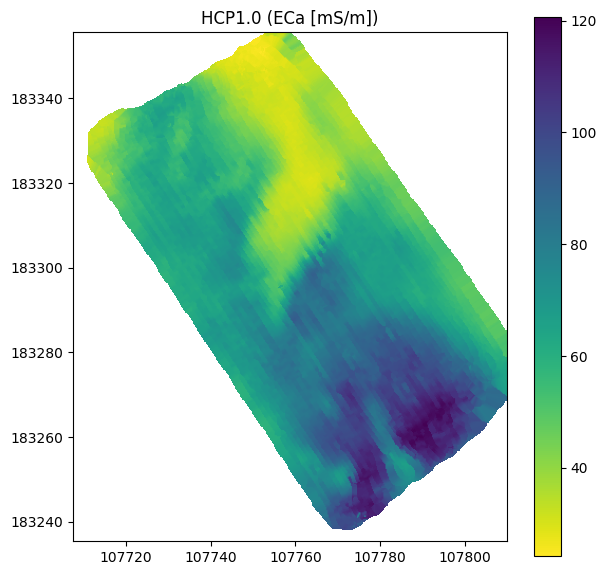

In [43]:
# 1.1: Example of interpolating and plotting a single FDEM dataset
# ----------------------------------------------------------------

save_to_file = True    # set to True to save the interpolated grid as a GeoTIF in your export directory

# Specify the data column of which you want to interpolate the values
col = 'HCP1.0'
cell_size = 0.25 # raster cell size in meters

f_name = '1m_HCP_ECa' # name of the exported GeoTIF file (in the example, 1m_HCP_ECa.tif will be the filename for the HCP1.0 dataset)

# ******************************************************************** #

# Interpolation function
data_grid = interpolate(df['x'], df['y'], df[col], cell_size=cell_size, blank=blank)

# Specify the grid extent for plotting with correct x-y coordinates
extent = data_grid['extent']

# Set units and colormap (cmap) for either IP or ECa data
if 'inph' in col:
        unit = 'IP [ppt]'
        cmap = 'gray_r'
else:
        unit = 'ECa [mS/m]'
        cmap = 'viridis_r'

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(data_grid['grid'], 
                origin='lower', 
                extent=(extent['x_min'],
                        extent['x_max'],
                        extent['y_min'],
                        extent['y_max']),
                cmap = 'viridis_r'
                )
# Set limits to the plotting range based on data percentiles by 
# uncommenting the 4 lines below: 

# pmin = 2  # lower percentile
# pmax = 98  # upper percentile 
# im.set_clim(np.percentile(data_grid['grid'].flatten()[~np.isnan(data_grid['grid'].flatten())], pmin),
#         np.percentile(data_grid['grid'].flatten()[~np.isnan(data_grid['grid'].flatten())], pmax))

ax.set_title(f"{col} ({unit})")
plt.colorbar(im, ax=ax)

# Export the grid as a GeoTIF

if save_to_file==True:
        """
        You can set the exported file's name by modifying the f_name variable
        """
        export_grid(data_grid, filename = f_name, export_path = export_path)

**_Code cell 1.2_** is a more advanced example of how you an iteratively interpolate and plot all datasets from the FDEM survey. Running this cell provides an overview of all collected ECa and IP datasets.

Take note that the interpolation algorithms implemented here have the primary purpose of quickly visualising data. These are very simple interpolators, from the [SciPy](https://docs.scipy.org/doc/scipy/tutorial/interpolate.html) package, that do not take geostatistical relationships or distances between points into account.

In [44]:
df_data_grids.keys()

RangeIndex(start=0, stop=0, step=1)

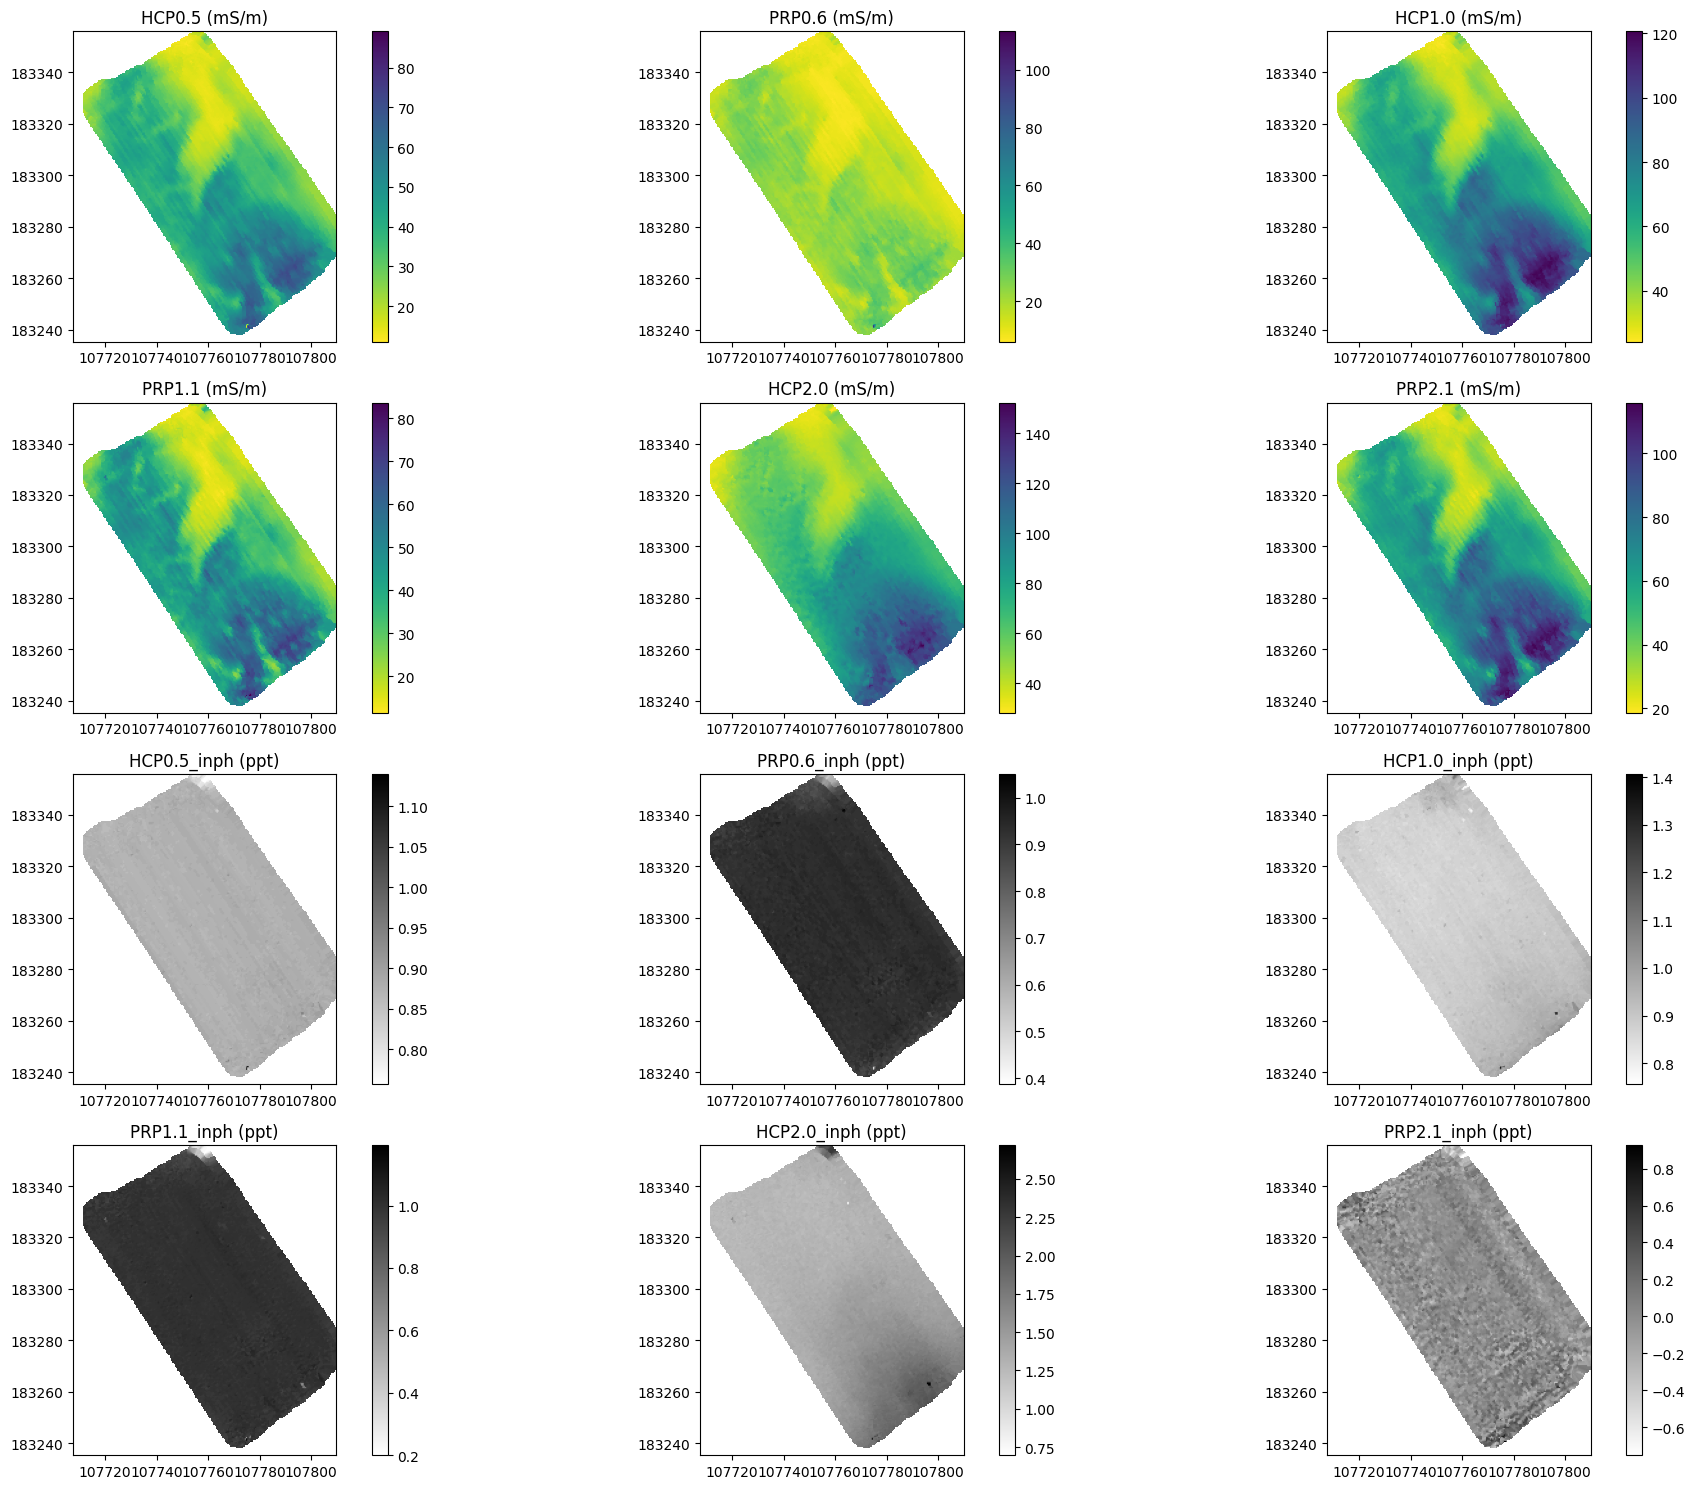

In [45]:
# 1.2: Example on interpolating and plotting via loop and visualise all datasets
# ------------------------------------------------------------------------------

save_to_file = True  # set to True to save the interpolated grid as a GeoTIF in your export directory

fig, axes = plt.subplots(4, 3, figsize=(20, 15))

i = 0
data_grids = {}
for col in df.columns:
    # Omit columns that do not contain measurement data
    if col not in ['x','y','z','t']:
        row, col_idx = divmod(i, 3)
        ax = axes[row, col_idx]

        # Set plotting properties for inphase and ECa data
        if '_inph' in col:
            cmap = 'gray_r'
            unit = 'ppt'
        else:
            cmap = 'viridis_r'
            unit = 'mS/m'

        # Interpolate the survey dataset
        data_grid = interpolate(df['x'], df['y'], df[col],
                                        cell_size=0.5, blank=blank)
        extent = data_grid['extent']
        gridplot = data_grid['grid']

        # Store the data grid in the dictionary with the column name as the key
        data_grids[col] = data_grid

        # Visualise the results
        im = ax.imshow(
                        gridplot, 
                        origin='lower', 
                        extent=(extent['x_min'],
                                extent['x_max'],
                                extent['y_min'],
                                extent['y_max']),
                        cmap = cmap
                        )
        ax.set_title(f"{col} ({unit})")
        plt.colorbar(im, ax=ax)
        i += 1
# df_data_grids = pd.DataFrame.from_dict(data_grids)
plt.tight_layout()
plt.show()

# Export the interpolated grids as GeoTIF files
if save_to_file==True:
    for key in data_grids.keys():
        export_grid(data_grids[key], filename = key, export_path = export_path)

# 2. FDEM data exploration

### Evaluating variability in FDEM datasets

Next, you can explore the variability in the FDEM data in a more in-depth way. In **_code cell 2.1_**, you can have a look at a function that allows generating the relative and cumulative sensitivity functions of the deployed coil pairs. This allows you to evaluate at which depth the coil geometry obtains its maximum sensitivity to changes in subsurface electrical conductivity (for the QP (or LIN ECa) response). 
Each of the conductivity maps (produced with a different coil configuration), represents the apparent electrical conductivity of a specific soil volume. The depth of investigation of each of these datasets can be approximated by the depth above which 70% of the signal response is obtained. Using the simplified sensitivity functions below, in **_code cell 2.2_** you can plot the cumulative sensitivities, along with a line that represents the 70% response threshold.


In [46]:
# 2.1: Documentation of the lin sens function
# -----------------------------------------------------

help(lin_sens)

Help on function lin_sens in module Utils.func:

lin_sens(geometry, maxdepth=3.0, n_int=100, sensor_height=0)
    Calculate approximative cumulative and relative sensitivities based on
    Keller & Frischknecht, 1966 and McNeill, 1980
    
    Parameters
    ----------
    geometry : str
        coil geometry identifier, combining orientation ('HCP' or 'PRP'),
        and Tx-Rx separation. 'HCP0.5'is thus a HCP orientation with a 0.5 m
        coil separation.
    
    maxdepth : float (optional, default=3.0)
        Maximum depth to evaluate the sensitivity (m).
    
    n_int : int (optional, default=100)
        Number of depth intervals to evaluate the sensitivity.
    
    sensor_height : float (optional, default=0)
        Height of the sensor above the ground (m).
    
    Returns
    -------
    rsens_QP : np.array
        Array of relative QP sensitivities obtained over the evaluated depths.
    
    csens_QP : np.array, optional
        Array of cumulative QP sensitivities ob

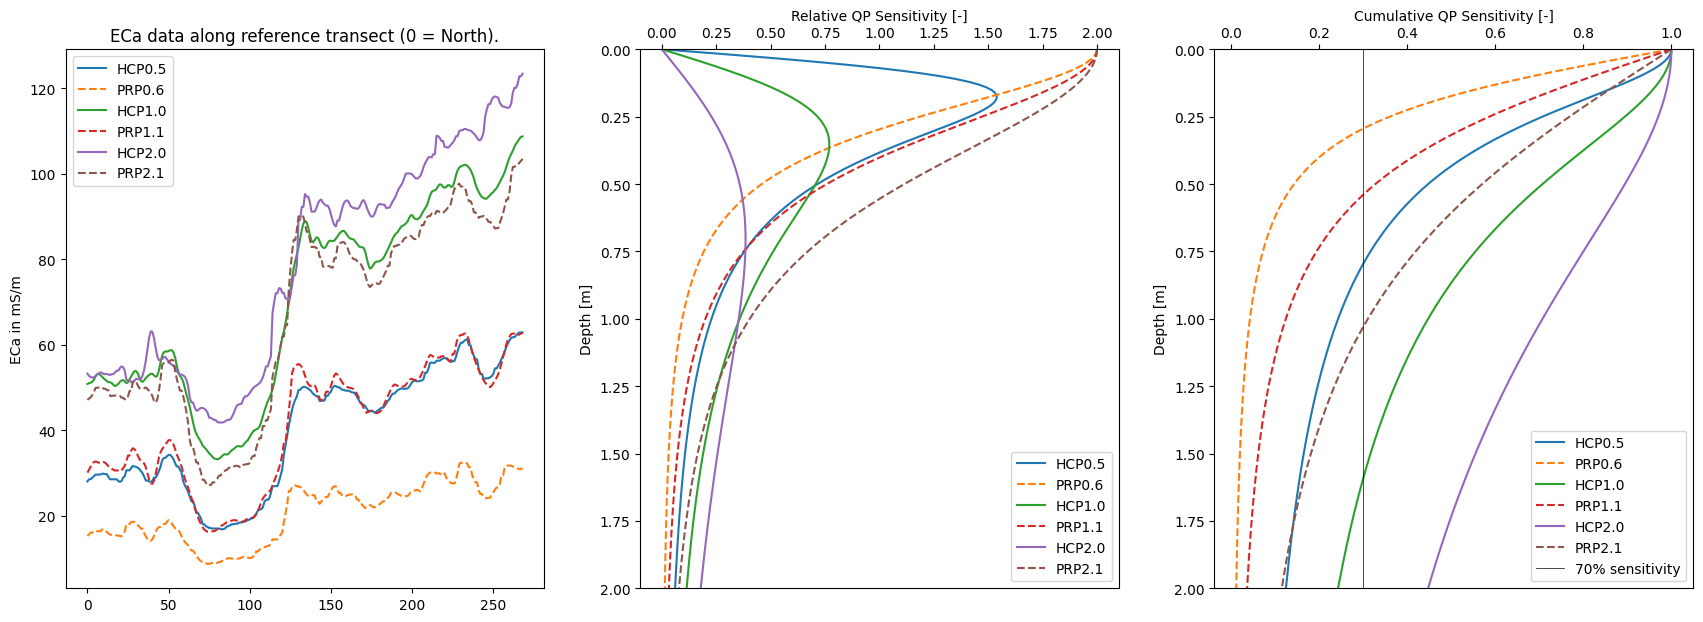

In [ ]:
# 2.2: Evaluating FDEM data along the reference transect
# ------------------------------------------------------

"""
Here you can compare plotted ECa data along the reference transect, 
and evaluate these at the sampling locations. In addition, you can 
evaluate the relative and cumulative sensitivity of the QP (LIN ECa) 
response of the deployed coil configurations. 
"""

save_to_file = True    # set to True to save the plots as a PDF in your export directory

maximum_depth = 2 # maximum depth to which you want to invert the data

# ******************************************************************** #

fig, axes = plt.subplots(1,3, figsize=(21,7))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]
for col in dt.columns:
    if col not in ['x','y','z','t','pos'] and 'inph' not in col:
        if 'PRP' in col:
            ax1.plot(dt[col], linestyle = 'dashed', label = col)
        else:
            ax1.plot(dt[col], label = col)
ax1.set_ylabel('ECa in mS/m')
ax1.set_title('ECa data along reference transect (0 = North).')
ax1.legend()

n_int = 200
depths = np.linspace(.0, maximum_depth, n_int)

for col in dt.columns:
    if col not in ['x','y','z','t','pos'] and 'inph' not in col:
        rsens_QP, csens_QP, rsens_IP, csens_IP = lin_sens(col, maximum_depth, n_int)
        if 'PRP' in col:
            ax2.plot(rsens_QP, depths, linestyle = 'dashed', label=col)
            ax3.plot(csens_QP, depths, linestyle = 'dashed', label=col)
        else:
            ax2.plot(rsens_QP, depths, label=col)
            ax3.plot(csens_QP, depths, label=col)

ax2.invert_yaxis()
ax2.set_ylim(maximum_depth, 0)
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Relative QP Sensitivity [-]')
ax2.set_ylabel('Depth [m]')
ax2.legend()

ax3.axvline(x=0.3, color='k', linestyle='-', linewidth=0.5, label='70% sensitivity')
ax3.invert_yaxis()
ax3.set_ylim(maximum_depth, 0)
ax3.xaxis.tick_top()
ax3.xaxis.set_label_position('top')
ax3.set_xlabel('Cumulative QP Sensitivity [-]')
ax3.set_ylabel('Depth [m]')
ax3.legend()

plt.show()

# Export the plots as a PDF
if save_to_file==True:
    with PdfPages(export_path + '/ECa_along_transect.pdf') as pdf:
        pdf.savefig(fig)

### Exploring data in QGIS

#### <ins> Loading FDEM data and the Flemish Soil Map in QGIS <ins>

With the above functions, you are all set to start exploring the FDEM data. If you have exported one or more of the FDEM datasets as geotifs, you can open these in a GIS (instructions here are for [QGIS](https://www.qgis.org/en/site/)) and compare the observed electromagnetic variations to known soil information.
In QGIS, and create a new project (Ctrl+N, or by using the menus). Set the coordinate reference system to Belgian Lambert 1972 (EPSG:31370).

Raster layers can be added by pressing Ctrl+Shift+R, or navigating to the `Layer > Add Layer > Add Raster Layer` menu item. 
You can also add the delimited text file (.csv-file) containing the sample data by pressing Ctrl+Shift+T or navigating to the `Layer > Add Layer > Add Delimited Text Layer` menu item. Make sure that you specific the columns with x- and y- coordinates correctly (X field = `x`; Y field = `y`).

You can add the Flemish soil map to your project by adding the WMS layer. (Alternatively, you can also do this via the Geoloket plugin if you have this installed.)
Do this by pressing CTRL-Shift-W (or via `Layer>Add Layer>Add WMS/WMTS Layer`). In the popup box you create a new service connection by pressing 'New'. You can enter a name to identify the layer (e.g. 'SoilMap'), and in the URL you copy this address: https://www.dov.vlaanderen.be/geoserver/bodemkaart/bodemtypes/wms?version=1.3.0&request=GetCapabilities&service=wms 

Then press 'Connect' and you should see the different layers in this WMS repository. If you select 1 -- bodemtypes, and Add this (click the button below), you have added the soil map to your project. You can explore the other layers in the WMS as well. Mainly the Digital Soil Map (1) and the drainage class map (2) are relevant for this study. 

The names are indicated in Dutch, but here you have them translated:

1. soil types - Digital Soil Map of the Flemish Region ('bodemtypes')
2. drainage classes (labeled)
3. soil series (labeled)
4. drainage classes (unlabeled)
5. soil series (simplified legend)
6. soil series (contours)
7. soil series (unlabeled)

#### <ins> Loading modelled soil property data based on the Flemish Soil Map in QGIS <ins>

Alongside the Flemish soil map, the Flemish governement provides specific soil property information, that is modeled based on the soil map and point data ([more info here](https://dov.vlaanderen.be/page/virtuele-bodemanalyse)). These datasets provide quantitative information on soil properties (texture, organic matter content, ...) for different soil depths. You can import these datasets as WMS layers in QGIS as well via this URL: https://oefen.dov.vlaanderen.be/geoserver/bdbstat/wms?version=1.3.0 , following the same procedure as above. When loading the WMS data, you can select different soil property maps (see the screenshot below). 


<img src='https://users.ugent.be/~pjdsmedt/ESS2024/base/mod_wms-01.png' width="800">

If you select one with the suffix 'basisdata_bodemkartering', you can select model data for different depths, which you can compare with FDEM data representative for different soil volumes or depths (see section 3. FDEM data inversion).

By evaluating these WMS datasets, you can compare the spatial patterning in the geophysical data to the information from the soil map, and to the sample information. You can use this QGIS project to combine and visualise all data from your project.

# 3. FDEM data inversion

Until now, you have worked with raw FDEM data. The QP output of the instrument is given as LIN ECa data, apparent EC data that consider a simple, linear relationship between the subsurface EC, and the QP instrument output. Hereby, the EC of all materials influencing the measurement is considered to be uniform, hence the 'apparent' nature of the data.
  
To evaluate the 'true' conductivity of the subsurface, we have to perform an inversion. In the following code cells, you can perform an inversion on the available FDEM datasets. More specifically, you can invert the ECa data layers collected during the survey, to model the subsurface conductivity. Through this process, you can create vertical sections (across the provided reference transect), and depth slices for specific depth ranges
  
To perform the inversion, we use the open-source EM modelling package [EMagPy](https://pypi.org/project/emagpy/), developed by [McLachlan et al. 2021](https://www.sciencedirect.com/science/article/pii/S0098300420305513). The sources code for this package is available on [GitHub](https://github.com/hkexgroup/emagpy/tree/master/src/emagpy).
  
All inversion procedures are driven by a forward model. As discussed, the forward model allows predicting the response obtained with a specific geophysical instrument used in a specific configuration, given an assumed subsurface model, described by a set of parameters. The underlying model builds on the sensitivities plotted in code block 1.2, only it integrates the cumulative sensitivity (CS) functions that describe how much of the total QP response (or, the ECa) of the instrument can be attributed to EC variations at different depths.
  
These CS functions assume that the sensitivity of the instrument depends only on the depth and the used coil configuration, and is independent of the subsurface EC and the instrument's operating frequency. More comprehensive models can be deployed as well in EMagPy, but these are beyond the scope of this exercise.

In **_code cell 3.0_**, you will perform an example inversion along the reference transect. The EMagPy program reads from .csv-files, so the dataset path is the URL that is specified at the beginning of this notebook (stored in the `FDEM_transect` variable). 
You will implement the inversion in a very basic way. The initial parameter you will set is:
- depths0: initial depths in meters of the bottom of each layer to be modelled. The bottom layer boundary is set to infinity (Numpy array with n depths).

By loading the .csv files, EMagPy automatically recognises the data columns and coil configurations, and makes use of all ECa datasets to perform the inversion.

All parameters of the inversion have been preset like this:
> `transect.invert(forwardModel='CS', alpha=0.13, njobs=-1)` 

This includes the forward model to use (the cumulative sensitivity), and an alpha parameter that smooths the inversion.

(<i>You can evaluate the use of different forward models by changing the > `forwardModel` argument in the function to 'FSlin' (which implements the full solution of Maxwell's equations, with LIN approximation) or with 'FSeq' (which implements the full solution of Maxwell's equations, without the approximation). These models are more robust, but come at a higher computational cost. A practical comparison of these procedures can be found [here](https://hkex.gitlab.io/emagpy/gallery/nb_paper-cs-vs-fs.html)<i>)

In [48]:
# 3.0: Performing an inversion along the reference transect
# ----------------------------------------------------------
# Set path to the FDEM transect data
data_path = FDEM_transect 

# Determine the starting model parameters
"""
starting depths* are generated here with np.arange** alternatively, you 
can manually create an array of depth boundary values (e.g., depths = [0.5,0.1],
for a 3-layer model with layer boundaries at 0.5 m and 1.0 m. 

* the minimum boundary depth has to be larger than 0

** np.arange creates a 1D array of evenly spaced values. In the example below
this is a 1D array of from 0.10 to 10, with a value interval of 0.1
"""

# Inversion interface depths from 0 - 2 m, with a 0.1 m interval
min_depth = 0.10
max_depth = 2.10
interval_m = 0.10
depths_in = np.arange(0.10, max_depth, interval_m) # np

# # Specific inversion interface depths
# depths_in = [0.2, 0.5, 1.0, 1.5, 2.0] # manual interface depths in meters

# # Inversion interface depths from 0 - 2 m, with a logarithmic interval
# n_log_spaces = 10
# depths_in = np.logspace(np.log10(min_depth), 
#                         np.log10(max_depth), 
#                         n_log_spaces) # log

"""
Defining starting conductivities is optional, but if you remove (or comment)
the line above, you have to remove that argument from the .setInit method 
below as `transect.setInit(depths0=depths_in)`.
"""

# ******************************************************************** #

# Create an inversion problem object to solve with EMagPy
transect = Problem()

# Create a survey object that stores the survey data (data_path) and 
# incorporates the instrument operating frequency (freq), the instrument height
# (hx), and the unit of the conductivity data to be evaluated (unit)

transect.createSurvey(data_path, freq=9000,hx=0.165,unit='ECa')
transect.setInit(depths0=depths_in)

# Run the inversion
transect.invert(forwardModel='CS', alpha=0.13, njobs=-1)
print('   Finished inversion')

100%|██████████| 269/269 [01:11<00:00,  3.77it/s]


   Finished inversion


### Plotting and exporting results <ins>along the reference transect<ins>

By running **_code cell 3.1_** you can plot the inversion results, and put these in a dataframe. 
Running the cell also exports the inversion results as a csv-file (you can modify the title if wanted). From the dataframe, you can then extract a single profile and plot it. In **_code cell 3.2_** this is done for a single position along the transect. You can specify the position (in meters) by changing the variable `transect_position`.

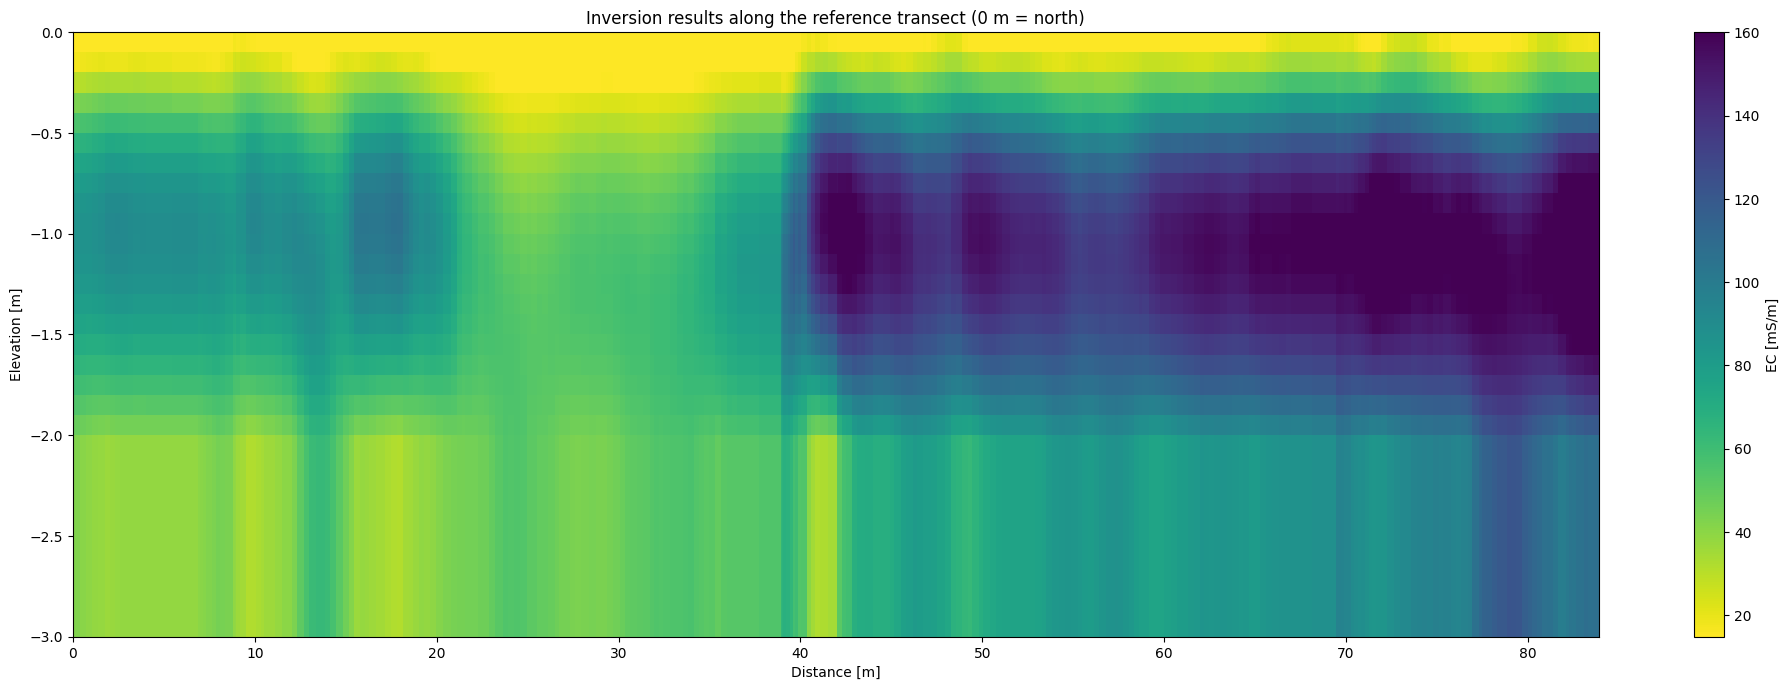

In [49]:
# 3.1: Plot the inversion results and put outcomes into a pandas dataframe
# ------------------------------------------------------------------------

save_to_file = True    # set to True to save the inverted data as a csv-file in your export directory

csv_filename = 'inverted_transect.csv'

# ******************************************************************** #

# Plot inversion outcomes down to a max depth of 2 m, and plotting the data
# based on their true coordinates along the transect (dist=True).

fig, ax_t = plt.subplots(figsize=(20,7))
transect.showResults(dist=True, ax=ax_t) 
ax_t.set_title('Inversion results along the reference transect (0 m = north)')

# Extracting the values from the first row of the transect.depths[0] array
depth_values = transect.depths[0][0]

# Creating the custom column names for layer_cols
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']

# Combining the data from the 'x', 'y' columns and the transect.models[0] array
data = np.c_[transect.surveys[0].df[['x', 'y']].values, transect.models[0]]

# Creating the final dataframe with the desired column names
dt_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
dt_inv['pos'] = dt['pos']
# ----------------------------------------------------------------------

# Export the dataframe as a csv-file
if save_to_file==True:

    dt_inv.to_csv(export_path + '/' + csv_filename, index=False)

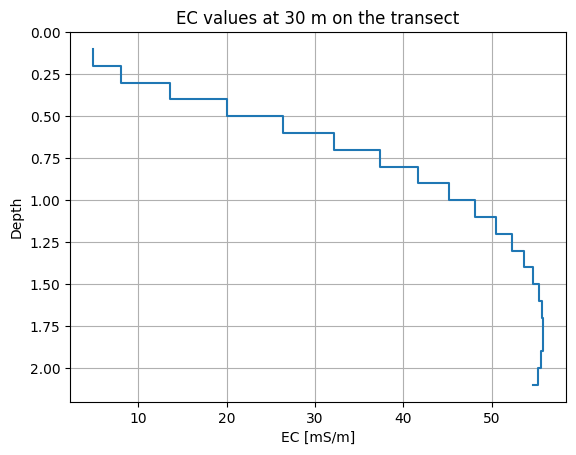

In [50]:
# 3.2: Plotting a single inverted profile based on its position.
# --------------------------------------------------------------

# Select the row index for which you want to plot the data

transect_position = 30  # profile position along the transect in meters
                        # North = 0

# ******************************************************************** #
# Extract the data for the selected position along the transect
closest_index = (dt_inv['pos'] - transect_position).abs().idxmin()
row_data = dt_inv.loc[closest_index, layer_cols].values

# Extract the depth values (excluding the 'EC_end' column)
depth_values = [float(col[3:]) for col in layer_cols[:-1]]

# Add the ending depth value (assuming equal spacing between depth values)
depth_values.append(depth_values[-1] + (depth_values[-1] - depth_values[-2]))

# Create the plot
plt.figure()
plt.step(row_data, depth_values)
plt.xlabel('EC [mS/m]')
plt.ylabel('Depth')
plt.title('EC values at {} m on the transect'.format(transect_position))
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

### Modelling EC variations <ins>at sampled locations<ins>

By running **_code cell 3.3_** you can perform an inversion on the FDEM data collected at the locations where you took invasive samples. You can set a specific depth extent for the subsurface layers. Instead of modelling the conductivity for each 10 cm layer as in the transect inversion, try setting the layer boundaries based on your prior knowledge of the soil buildup, instead of modelling the conductivity for 10 cm thick layers as in the example above.
This prior knowledge can be derived from the samples you took on the field, most importantly the soil profile descriptions and the downhole conductivity measurements.

You will instantly plot the results, and write the outcome to a pdf. If you are happy with the results, and want to have these data in a csv file run **_code cell 3.4_** to export these.

100%|██████████| 15/15 [00:00<00:00, 125.37it/s]


   Finished inversion


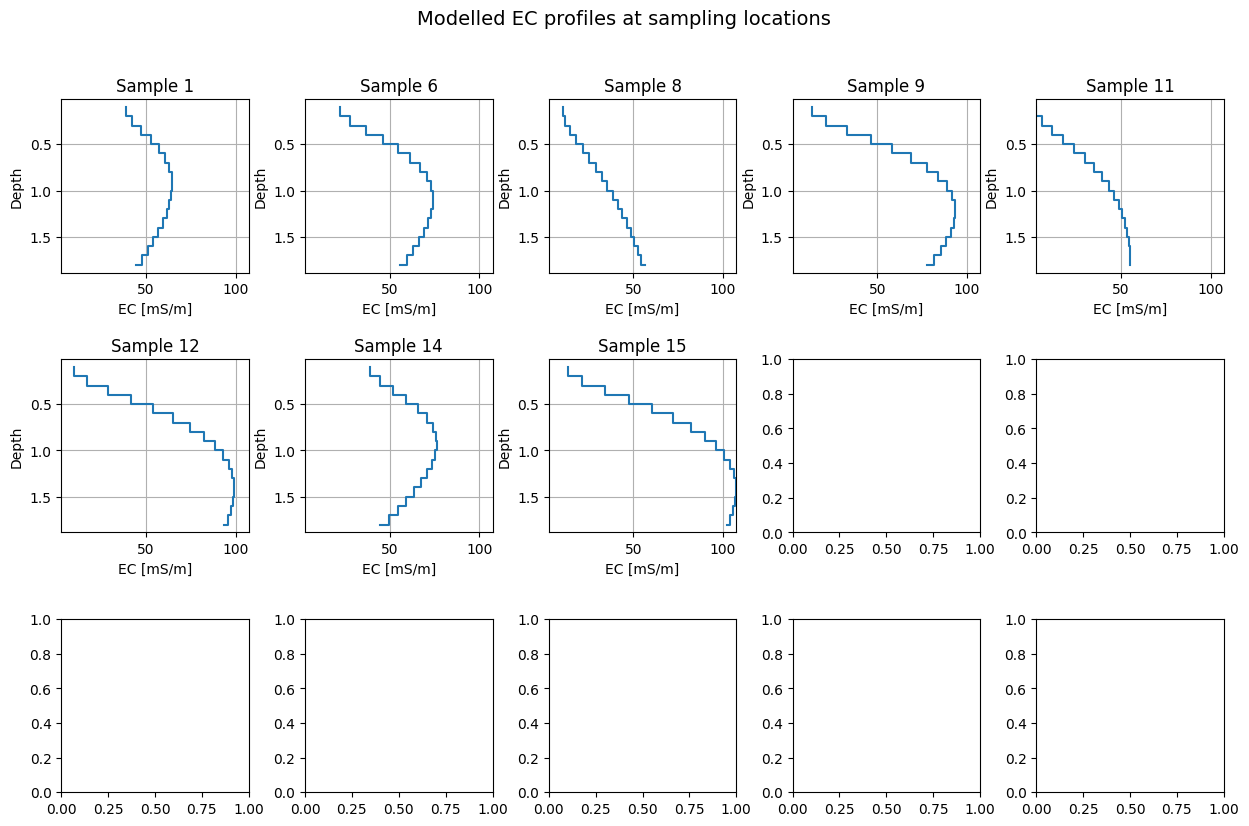

In [51]:
# 3.3: Inversion at the sampling locations
# -----------------------------------------

# Determine the inversion parameters (layer boundary depths & conductivities)
'''
Here is an example for a 2 layer model with boundaries at 0.5 and 1 m. 
You can adjust de starting depths array (`depths_in`). Try creating a 
3-layer model based on the observations you made on the field
'''
save_to_file = True    # set to True to save the inverted data as a csv-file in your export directory

#depths_in = [0.6,1.0] 
depths_in = np.arange(0.10, 1.75, 0.10) 

# Set pdf name for exporting plot
pdf_name = 'Modelled_EC_profiles.pdf'

# ******************************************************************** #
# Create an inversion problem object to solve with EMagPy

sampling_path = samples
sample_transect = Problem()
sample_transect.createSurvey(sampling_path, freq=9000,hx=0.165,unit='ECa')
sample_transect.setInit(depths0=depths_in)

# Run the inversion
sample_transect.invert(forwardModel='CS', alpha=0.23, njobs=-1)
print('   Finished inversion')

# ----------------------------------------------------------------------
# Plotting and exporting the EC profiles figure as a pdf
# ----------------------------------------------------------------------

# Putting the results in a dataframe, and concatenate with analytical data.
depth_values = sample_transect.depths[0][0]
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']
data = np.c_[sample_transect.surveys[0].df[['x', 'y']].values, 
             sample_transect.models[0]]

ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
selected_columns_ds = pd.concat([ds.iloc[:, 4:11], ds.iloc[:, 17:]], axis=1)
ds_all = pd.concat([ds_inv, selected_columns_ds], axis=1)
ds_all = ds_all.dropna()

unique_sample_ids = ds_all['ID'].unique()

# Calculate number of rows and columns for the subplot
subplot_rows = 3
subplot_cols = 5

# Get axis limits
global_x_min = ds_all[layer_cols].min().min()
global_x_max = ds_all[layer_cols].max().max()


# Create the subplots
fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=(15, 9))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Loop through each sample ID and plot the EC values
for i, sample_id in enumerate(unique_sample_ids):
    # Get row index for the current sample ID
    row_index = ds_all.loc[ds_all['ID'] == sample_id].index[0]
    row_data = ds_all.loc[row_index, layer_cols].values

    # Extract depth values
    depth_values = [float(col[3:]) for col in layer_cols[:-1]]
    depth_values.append(depth_values[-1] + (depth_values[-1] - depth_values[-2]))

    # Get the current subplot axis
    ax = axes[i // subplot_cols, i % subplot_cols]

    # Plot the data
    ax.step(row_data, depth_values)
    ax.set_xlabel('EC [mS/m]')
    ax.set_ylabel('Depth')
    ax.set_title(f'Sample {int(sample_id)}')
    ax.set_xlim(global_x_min, global_x_max)
    ax.invert_yaxis()
    ax.grid(True)

fig.suptitle('Modelled EC profiles at sampling locations', fontsize=14)

# Save the plot as a PDF file
if save_to_file==True:
    with PdfPages(export_path + '/' + pdf_name) as pdf:
        pdf.savefig(fig)

# Show the subplots
plt.show()

In [52]:
# 3.4: Export as a csv-file
csv_filename = 'inverted_samples.csv'

ds_all.to_csv(export_path + '/' + csv_filename, index=False)

# ******************************************************************** #

### Modelling EC variations <ins>for the entire survey dataset<ins>

After evaluating the outcomes of the inversion conducted in the previous cells, you can apply the inversion to the entire survey dataset. Hereby, you can target specific layers in the subsurface, and model their electrical conductivity. This follows the same flow as in the previous code cells, only now you will not visualise the data along a transect (vertical slice), but you will create horizontal EC slices that represent the electrical conductivities of the layers you define by setting the model depths.

Considering the availability of sampling information from the upper part of the soil, your main goal is to predict the spatial variability of your target properties across the entire survey area. 

In **_Code cell 3.5_** you can perform the inversion. Set the boundaries of the layers for which you want to predict the electrical conductivity at the desired depth. Base the depth boundary on the inversion results you obtained above, and on your prior knowledge of the subsurface (boreholes, downhole-ec data). In the example, the depths are similar as the initial examples above (`depths_in = [0.6,1.0]`). <ins>The results are exported as a .csv-file of which you can set the name.<ins>

By running **_Code cell 3.6_**, you can visualise all depth slices that you have created. <ins>By setting the export condition (`export_rasters`) to `True`, you can export these slices<ins> as GeoTIFs using the interpolation and export functions from code cell 1.0.

In [53]:
# 3.5: Inverting the full survey dataset
# --------------------------------------
''' 
runtime when creating 3-layer model: ca. 10 mins in Google Colaboratory
'''
save_to_file = False   # set to True to save the inverted data as a csv-file in your export directory

depths_in = [0.6,1.0] 
csv_filename = 'inverted_survey.csv'

# ******************************************************************** #

file_path = FDEM_surveydata
survey = Problem()
survey.createSurvey(file_path, freq=9000,hx=0.165)
survey.setInit(depths0=depths_in)
survey.invert(forwardModel='CS',
              method='L-BFGS-B',
              alpha=0.23,njobs=-1)

# Putting the results in a dataframe, and concatenate with analytical data.
depth_values = survey.depths[0][0]
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']
data = np.c_[survey.surveys[0].df[['x', 'y']].values, 
             survey.models[0]]

inv_df = pd.DataFrame(data, columns=['x','y'] + layer_cols)

# Export to csv
if save_to_file == True:
    inv_df.to_csv(export_path + '/' + csv_filename, index=False)

100%|██████████| 26283/26283 [09:04<00:00, 48.27it/s]


In [ ]:
# 3.6: Interpolate, plot and export the inversion results
# -------------------------------------------------------

# Set the cell_size
cell_size = 0.25


save_to_file = False # set to True to save the final rasters as a GeoTIF in your export directory

# ******************************************************************** #

# Calculate the number of rows and columns for subplots based on the number of layer_cols
n = len(layer_cols)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))

# Calculate the global minimum and maximum values across all datasets
global_min = min([inv_df[col].min() for col in layer_cols])
global_max = max([inv_df[col].max() for col in layer_cols])

# Create a figure with subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))
axes = axes.flatten()

# Iterate over the layer columns, interpolate the data, and plot the results
for i, col in enumerate(layer_cols):
    
    data_grid = interpolate(inv_df['x'], inv_df['y'], inv_df[col], cell_size)
    extent = data_grid['extent']
    im = axes[i].imshow(data_grid['grid'], origin='lower', 
                        extent=(extent['x_min'],
                                extent['x_max'],
                                extent['y_min'], 
                                extent['y_max']),
                                cmap = 'viridis_r',
                                vmin=global_min, vmax=global_max)
    
    # Extract float values from column names
    float_value = float(re.findall(r"(\d+\.\d+)", col)[0]) if re.findall(r"(\d+\.\d+)", col) else None
    
    # Set the title
    if col == 'EC_end':
        title = 'EC bottom layer'
    elif i == 0:
        title = f'EC 0 - {float_value:.2f} m'
    else:
        prev_float_value = float(re.findall(r"(\d+\.\d+)", layer_cols[i-1])[0])
        title = f'EC {prev_float_value:.2f} - {float_value:.2f} m'
    
    axes[i].set_title(title)
    fig.colorbar(im, ax=axes[i])

    # Export to GeoTIF if wanted
    if save_to_file == True:

        export_grid(data_grid, filename=title, export_path = export_path)

# Remove any unused subplots
for i in range(n, len(axes)):
    axes[i].axis('off')

# Display the figure
plt.show()